# VAE Training

## Import libraries

In [1]:
#Basic
import os
import numpy as np

#path
import sys
sys.path.append("../")

#Custom
import config
from src.models.train_model import sampling,encoder_model,decoder_model,vae_model,vae_loss
from src.models.callbacks import tensorboard,checkpoint,reduce_lr
from src.visualization.visualize import plot_learning_curve
from config import intermediate_dim,latent_dim,batch_size,epochs

Using TensorFlow backend.


In [2]:
# Deep Learning
import keras
print(f"Keras version {keras.__version__}")

import tensorflow as tf
print(f"Tensorflow version {tf.__version__}")


from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.utils import plot_model
from keras import backend as K
from keras.optimizers import RMSprop
from keras.metrics import binary_crossentropy


Keras version 2.3.1
Tensorflow version 1.14.0


# Check data

Get (n_samples,width,height) into (n_samples,flatten_dimension)

In [7]:
os.listdir(config.DATA_PREPROCESSED_DIR)

['y_test.npy',
 'X_train.npy',
 'X_valid.npy',
 'X_test.npy',
 'y_valid.npy',
 'y_train.npy']

In [8]:
X_train = np.load(os.path.join(config.DATA_PREPROCESSED_DIR,"X_train.npy"))
X_test = np.load(os.path.join(config.DATA_PREPROCESSED_DIR,"X_test.npy"))
X_valid = np.load(os.path.join(config.DATA_PREPROCESSED_DIR,"X_valid.npy"))

y_train = np.load(os.path.join(config.DATA_PREPROCESSED_DIR,"y_train.npy"))
y_test = np.load(os.path.join(config.DATA_PREPROCESSED_DIR,"y_test.npy"))
y_valid = np.load(os.path.join(config.DATA_PREPROCESSED_DIR,"y_valid.npy"))

input_shape = X_train[0].shape
original_dim = X_train[0].shape


In [9]:
print("Shapes info : \n")
print(f"X_train shape : {X_train.shape}")
print(f"X_test shape : {X_test.shape}")
print(f"X_valid shape : {X_valid.shape}")

print(f"y_train shape : {y_train.shape}")
print(f"y_test shape : {y_test.shape}")
print(f"input shape : {input_shape}")
print(f"output shape : {original_dim}")

Shapes info : 

X_train shape : (900, 900)
X_test shape : (180, 900)
X_valid shape : (120, 900)
y_train shape : (900, 900)
y_test shape : (180, 900)
input shape : (900,)
output shape : (900,)


In [10]:
print("Settings_info\n")
print(f"Intermediate_dim :  {intermediate_dim}")
print(f"Latent_dim : {latent_dim}")
print(f"Epochs : {epochs}")
print(f"Batch_size : {batch_size}")

Settings_info

Intermediate_dim :  512
Latent_dim : 2
Epochs : 1000
Batch_size : 128


# Initialize encoder 

In [11]:
inputs = Input(shape=input_shape, name='encoder_input')
encoder, z_mean, z_log_var = encoder_model(inputs)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 900)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          461312      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_1[0][0]                    
____________________________________________________________________________________________

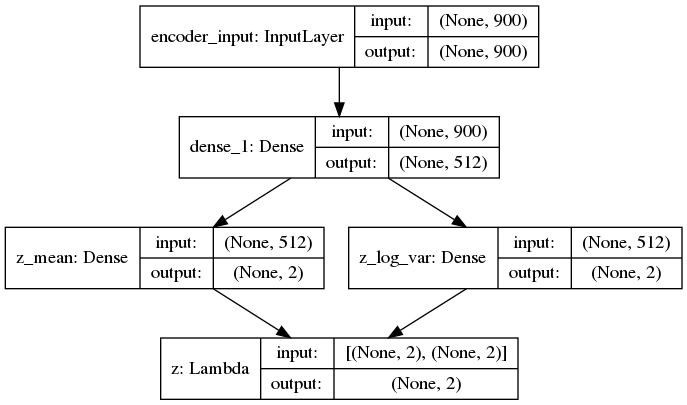

In [13]:
plot_model(encoder,show_shapes=True)

# Initialize decoder

## Decoder model

1. Tworzymy warstwe latent_input na wejscie podajac latend_dim
2. Następnie dodajemy warstwę pośrednią z tylu neuronów ilu chcieliśmy
3. Tworzymy warstwę wyjściową
4. zwracamy dekoder

In [14]:
original_dim = X_train[0].shape
decoder = decoder_model(original_dim)
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_3 (Dense)              (None, 900)               461700    
Total params: 463,236
Trainable params: 463,236
Non-trainable params: 0
_________________________________________________________________


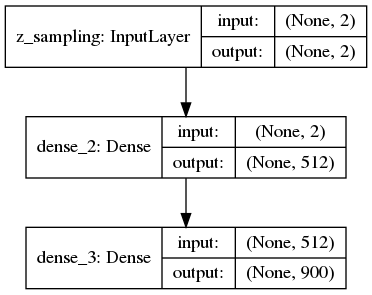

In [15]:
plot_model(decoder,show_shapes=True)

# Instantiate VAE model

In [16]:
outputs = decoder(encoder(inputs)[2])#biore outputy z dekodera
vae = Model(inputs, outputs, name='vae_mlp') # tworzę VAE

In [17]:
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 900)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 463364    
_________________________________________________________________
decoder (Model)              (None, 900)               463236    
Total params: 926,600
Trainable params: 926,600
Non-trainable params: 0
_________________________________________________________________


# Compile model

In [18]:
def vae_loss(y_true, y_pred):
    xent_loss = binary_crossentropy(K.flatten(y_true), K.flatten(y_pred))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

In [19]:
# Compile model
optimizer = RMSprop(lr=0.000007, rho=0.9, decay=0.0)
loss = vae_loss
vae.compile(optimizer=optimizer, loss=loss)

# Training

In [20]:
history = vae.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size,
            callbacks=[tensorboard, checkpoint, reduce_lr])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/1000
900/900 [==============================] - 0s 318us/step - loss: 0.8166

Epoch 00001: loss improved from inf to 0.81661, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 2/1000
900/900 [==============================] - 0s 113us/step - loss: 0.7171

Epoch 00002: loss improved from 0.81661 to 0.71709, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 3/1000
900/900 [==============================] - 0s 106us/step - loss: 0.7042

Epoch 00003: loss improved from 0.71709 to 0.70423, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 4/1000
900/900 [==============================] - 0s 111us/step - loss: 0.7025

Epoch 00004: loss improved from 0.70423 to 0.70248, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 5/1000
900/900 [==============================] - 0

900/900 [==============================] - 0s 92us/step - loss: 0.6845

Epoch 00038: loss improved from 0.68475 to 0.68454, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 39/1000
900/900 [==============================] - 0s 106us/step - loss: 0.6841

Epoch 00039: loss improved from 0.68454 to 0.68413, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 40/1000
900/900 [==============================] - 0s 97us/step - loss: 0.6838

Epoch 00040: loss improved from 0.68413 to 0.68381, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 41/1000
900/900 [==============================] - 0s 120us/step - loss: 0.6832

Epoch 00041: loss improved from 0.68381 to 0.68317, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 42/1000
900/900 [==============================] - 0s 111us/step - loss: 0.6821

Epoch 00042: loss improved from 0.68317 to 0.68213, saving model to /home

900/900 [==============================] - 0s 100us/step - loss: 0.6658

Epoch 00081: loss improved from 0.66792 to 0.66584, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 82/1000
900/900 [==============================] - 0s 171us/step - loss: 0.6666

Epoch 00082: loss did not improve from 0.66584
Epoch 83/1000
900/900 [==============================] - 0s 161us/step - loss: 0.6652

Epoch 00083: loss improved from 0.66584 to 0.66520, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 84/1000
900/900 [==============================] - 0s 118us/step - loss: 0.6664

Epoch 00084: loss did not improve from 0.66520
Epoch 85/1000
900/900 [==============================] - 0s 109us/step - loss: 0.6655

Epoch 00085: loss did not improve from 0.66520
Epoch 86/1000
900/900 [==============================] - 0s 143us/step - loss: 0.6649

Epoch 00086: loss improved from 0.66520 to 0.66486, saving model to /home/michal/Desktop/ML_Proje

900/900 [==============================] - 0s 135us/step - loss: 0.6460

Epoch 00128: loss improved from 0.64733 to 0.64599, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 129/1000
900/900 [==============================] - 0s 151us/step - loss: 0.6474

Epoch 00129: loss did not improve from 0.64599
Epoch 130/1000
900/900 [==============================] - 0s 117us/step - loss: 0.6450

Epoch 00130: loss improved from 0.64599 to 0.64497, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 131/1000
900/900 [==============================] - 0s 95us/step - loss: 0.6446

Epoch 00131: loss improved from 0.64497 to 0.64462, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 132/1000
900/900 [==============================] - 0s 100us/step - loss: 0.6455

Epoch 00132: loss did not improve from 0.64462
Epoch 133/1000
900/900 [==============================] - 0s 118us/step - loss: 0.6440

Epoch 00133: 

Epoch 175/1000
900/900 [==============================] - 0s 188us/step - loss: 0.6255

Epoch 00175: loss did not improve from 0.62520
Epoch 176/1000
900/900 [==============================] - 0s 120us/step - loss: 0.6254

Epoch 00176: loss did not improve from 0.62520
Epoch 177/1000
900/900 [==============================] - 0s 138us/step - loss: 0.6247

Epoch 00177: loss improved from 0.62520 to 0.62471, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 178/1000
900/900 [==============================] - 0s 124us/step - loss: 0.6237

Epoch 00178: loss improved from 0.62471 to 0.62366, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 179/1000
900/900 [==============================] - 0s 143us/step - loss: 0.6255

Epoch 00179: loss did not improve from 0.62366
Epoch 180/1000
900/900 [==============================] - 0s 134us/step - loss: 0.6239

Epoch 00180: loss did not improve from 0.62366
Epoch 181/1000
900/900 [======

900/900 [==============================] - 0s 148us/step - loss: 0.6079

Epoch 00223: loss did not improve from 0.60427
Epoch 224/1000
900/900 [==============================] - 0s 140us/step - loss: 0.6027

Epoch 00224: loss improved from 0.60427 to 0.60270, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 225/1000
900/900 [==============================] - 0s 136us/step - loss: 0.6030

Epoch 00225: loss did not improve from 0.60270
Epoch 226/1000
900/900 [==============================] - 0s 154us/step - loss: 0.6012

Epoch 00226: loss improved from 0.60270 to 0.60118, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 227/1000
900/900 [==============================] - 0s 108us/step - loss: 0.6000

Epoch 00227: loss improved from 0.60118 to 0.60002, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 228/1000
900/900 [==============================] - 0s 129us/step - loss: 0.5996

Epoch 00228:

900/900 [==============================] - 0s 149us/step - loss: 0.5798

Epoch 00271: loss did not improve from 0.57970
Epoch 272/1000
900/900 [==============================] - 0s 122us/step - loss: 0.5788

Epoch 00272: loss improved from 0.57970 to 0.57883, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 273/1000
900/900 [==============================] - 0s 144us/step - loss: 0.5778

Epoch 00273: loss improved from 0.57883 to 0.57783, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 274/1000
900/900 [==============================] - 0s 135us/step - loss: 0.5812

Epoch 00274: loss did not improve from 0.57783
Epoch 275/1000
900/900 [==============================] - 0s 115us/step - loss: 0.5780

Epoch 00275: loss did not improve from 0.57783
Epoch 276/1000
900/900 [==============================] - 0s 93us/step - loss: 0.5788

Epoch 00276: loss did not improve from 0.57783
Epoch 277/1000
900/900 [======================

900/900 [==============================] - 0s 84us/step - loss: 0.5576

Epoch 00318: loss did not improve from 0.55552
Epoch 319/1000
900/900 [==============================] - 0s 116us/step - loss: 0.5553

Epoch 00319: loss improved from 0.55552 to 0.55528, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 320/1000
900/900 [==============================] - 0s 86us/step - loss: 0.5556

Epoch 00320: loss did not improve from 0.55528
Epoch 321/1000
900/900 [==============================] - 0s 84us/step - loss: 0.5549

Epoch 00321: loss improved from 0.55528 to 0.55490, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 322/1000
900/900 [==============================] - 0s 89us/step - loss: 0.5510

Epoch 00322: loss improved from 0.55490 to 0.55102, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 323/1000
900/900 [==============================] - 0s 114us/step - loss: 0.5529

Epoch 00323: los

900/900 [==============================] - 0s 85us/step - loss: 0.5333

Epoch 00370: loss did not improve from 0.53024
Epoch 371/1000
900/900 [==============================] - 0s 84us/step - loss: 0.5287

Epoch 00371: loss improved from 0.53024 to 0.52869, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 372/1000
900/900 [==============================] - 0s 85us/step - loss: 0.5267

Epoch 00372: loss improved from 0.52869 to 0.52671, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 373/1000
900/900 [==============================] - 0s 87us/step - loss: 0.5304

Epoch 00373: loss did not improve from 0.52671
Epoch 374/1000
900/900 [==============================] - 0s 87us/step - loss: 0.5276

Epoch 00374: loss did not improve from 0.52671
Epoch 375/1000
900/900 [==============================] - 0s 88us/step - loss: 0.5270

Epoch 00375: loss did not improve from 0.52671
Epoch 376/1000
900/900 [===========================

900/900 [==============================] - 0s 85us/step - loss: 0.5028

Epoch 00422: loss improved from 0.50336 to 0.50277, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 423/1000
900/900 [==============================] - 0s 86us/step - loss: 0.5040

Epoch 00423: loss did not improve from 0.50277
Epoch 424/1000
900/900 [==============================] - 0s 85us/step - loss: 0.5035

Epoch 00424: loss did not improve from 0.50277
Epoch 425/1000
900/900 [==============================] - 0s 85us/step - loss: 0.5046

Epoch 00425: loss did not improve from 0.50277
Epoch 426/1000
900/900 [==============================] - 0s 83us/step - loss: 0.5041

Epoch 00426: loss did not improve from 0.50277
Epoch 427/1000
900/900 [==============================] - 0s 83us/step - loss: 0.5004

Epoch 00427: loss improved from 0.50277 to 0.50042, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 428/1000
900/900 [===========================

Epoch 473/1000
900/900 [==============================] - 0s 83us/step - loss: 0.4813

Epoch 00473: loss did not improve from 0.47792
Epoch 474/1000
900/900 [==============================] - 0s 85us/step - loss: 0.4813

Epoch 00474: loss did not improve from 0.47792
Epoch 475/1000
900/900 [==============================] - 0s 85us/step - loss: 0.4777

Epoch 00475: loss improved from 0.47792 to 0.47769, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 476/1000
900/900 [==============================] - 0s 102us/step - loss: 0.4807

Epoch 00476: loss did not improve from 0.47769
Epoch 477/1000
900/900 [==============================] - 0s 84us/step - loss: 0.4793

Epoch 00477: loss did not improve from 0.47769
Epoch 478/1000
900/900 [==============================] - 0s 88us/step - loss: 0.4798

Epoch 00478: loss did not improve from 0.47769
Epoch 479/1000
900/900 [==============================] - 0s 106us/step - loss: 0.4806

Epoch 00479: loss did not i

900/900 [==============================] - 0s 85us/step - loss: 0.4550

Epoch 00526: loss did not improve from 0.45248
Epoch 527/1000
900/900 [==============================] - 0s 86us/step - loss: 0.4592

Epoch 00527: loss did not improve from 0.45248
Epoch 528/1000
900/900 [==============================] - 0s 82us/step - loss: 0.4574

Epoch 00528: loss did not improve from 0.45248
Epoch 529/1000
900/900 [==============================] - 0s 84us/step - loss: 0.4502

Epoch 00529: loss improved from 0.45248 to 0.45024, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 530/1000
900/900 [==============================] - 0s 86us/step - loss: 0.4534

Epoch 00530: loss did not improve from 0.45024
Epoch 531/1000
900/900 [==============================] - 0s 87us/step - loss: 0.4524

Epoch 00531: loss did not improve from 0.45024
Epoch 532/1000
900/900 [==============================] - 0s 84us/step - loss: 0.4538

Epoch 00532: loss did not improve from 0.450

900/900 [==============================] - 0s 85us/step - loss: 0.4312

Epoch 00581: loss improved from 0.43134 to 0.43120, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 582/1000
900/900 [==============================] - 0s 87us/step - loss: 0.4273

Epoch 00582: loss improved from 0.43120 to 0.42730, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 583/1000
900/900 [==============================] - 0s 84us/step - loss: 0.4311

Epoch 00583: loss did not improve from 0.42730
Epoch 584/1000
900/900 [==============================] - 0s 86us/step - loss: 0.4300

Epoch 00584: loss did not improve from 0.42730
Epoch 585/1000
900/900 [==============================] - 0s 84us/step - loss: 0.4286

Epoch 00585: loss did not improve from 0.42730
Epoch 586/1000
900/900 [==============================] - 0s 82us/step - loss: 0.4264

Epoch 00586: loss improved from 0.42730 to 0.42643, saving model to /home/michal/Desktop/ML_Projec

Epoch 631/1000
900/900 [==============================] - 0s 85us/step - loss: 0.4103

Epoch 00631: loss did not improve from 0.40886
Epoch 632/1000
900/900 [==============================] - 0s 84us/step - loss: 0.4109

Epoch 00632: loss did not improve from 0.40886
Epoch 633/1000
900/900 [==============================] - 0s 84us/step - loss: 0.4091

Epoch 00633: loss did not improve from 0.40886
Epoch 634/1000
900/900 [==============================] - 0s 96us/step - loss: 0.4110

Epoch 00634: loss did not improve from 0.40886
Epoch 635/1000
900/900 [==============================] - 0s 116us/step - loss: 0.4117

Epoch 00635: loss did not improve from 0.40886
Epoch 636/1000
900/900 [==============================] - 0s 108us/step - loss: 0.4114

Epoch 00636: loss did not improve from 0.40886
Epoch 637/1000
900/900 [==============================] - 0s 129us/step - loss: 0.4071

Epoch 00637: loss improved from 0.40886 to 0.40710, saving model to /home/michal/Desktop/ML_Projects/eeg2i

900/900 [==============================] - 0s 86us/step - loss: 0.3947

Epoch 00682: loss did not improve from 0.39115
Epoch 683/1000
900/900 [==============================] - 0s 87us/step - loss: 0.3904

Epoch 00683: loss improved from 0.39115 to 0.39041, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 684/1000
900/900 [==============================] - 0s 83us/step - loss: 0.3889

Epoch 00684: loss improved from 0.39041 to 0.38886, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 685/1000
900/900 [==============================] - 0s 85us/step - loss: 0.3911

Epoch 00685: loss did not improve from 0.38886
Epoch 686/1000
900/900 [==============================] - 0s 85us/step - loss: 0.3884

Epoch 00686: loss improved from 0.38886 to 0.38841, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 687/1000
900/900 [==============================] - 0s 86us/step - loss: 0.3887

Epoch 00687: loss 

900/900 [==============================] - 0s 99us/step - loss: 0.3724

Epoch 00734: loss did not improve from 0.37069
Epoch 735/1000
900/900 [==============================] - 0s 103us/step - loss: 0.3748

Epoch 00735: loss did not improve from 0.37069
Epoch 736/1000
900/900 [==============================] - 0s 85us/step - loss: 0.3707

Epoch 00736: loss did not improve from 0.37069
Epoch 737/1000
900/900 [==============================] - 0s 86us/step - loss: 0.3707

Epoch 00737: loss did not improve from 0.37069
Epoch 738/1000
900/900 [==============================] - 0s 89us/step - loss: 0.3703

Epoch 00738: loss improved from 0.37069 to 0.37033, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 739/1000
900/900 [==============================] - 0s 88us/step - loss: 0.3699

Epoch 00739: loss improved from 0.37033 to 0.36991, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 740/1000
900/900 [==========================

900/900 [==============================] - 0s 93us/step - loss: 0.3526

Epoch 00787: loss improved from 0.35514 to 0.35261, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 788/1000
900/900 [==============================] - 0s 99us/step - loss: 0.3554

Epoch 00788: loss did not improve from 0.35261
Epoch 789/1000
900/900 [==============================] - 0s 103us/step - loss: 0.3556

Epoch 00789: loss did not improve from 0.35261
Epoch 790/1000
900/900 [==============================] - 0s 93us/step - loss: 0.3555

Epoch 00790: loss did not improve from 0.35261
Epoch 791/1000
900/900 [==============================] - 0s 107us/step - loss: 0.3583

Epoch 00791: loss did not improve from 0.35261
Epoch 792/1000
900/900 [==============================] - 0s 88us/step - loss: 0.3545

Epoch 00792: loss did not improve from 0.35261
Epoch 793/1000
900/900 [==============================] - 0s 133us/step - loss: 0.3556

Epoch 00793: loss did not improve from 0.

900/900 [==============================] - 0s 112us/step - loss: 0.3401

Epoch 00840: loss improved from 0.34114 to 0.34010, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 841/1000
900/900 [==============================] - 0s 141us/step - loss: 0.3407

Epoch 00841: loss did not improve from 0.34010
Epoch 842/1000
900/900 [==============================] - 0s 135us/step - loss: 0.3416

Epoch 00842: loss did not improve from 0.34010
Epoch 843/1000
900/900 [==============================] - 0s 133us/step - loss: 0.3419

Epoch 00843: loss did not improve from 0.34010
Epoch 844/1000
900/900 [==============================] - 0s 126us/step - loss: 0.3398

Epoch 00844: loss improved from 0.34010 to 0.33983, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 845/1000
900/900 [==============================] - 0s 130us/step - loss: 0.3409

Epoch 00845: loss did not improve from 0.33983
Epoch 846/1000
900/900 [=====================

900/900 [==============================] - 0s 110us/step - loss: 0.3291

Epoch 00892: loss did not improve from 0.32880
Epoch 893/1000
900/900 [==============================] - 0s 110us/step - loss: 0.3284

Epoch 00893: loss improved from 0.32880 to 0.32839, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 894/1000
900/900 [==============================] - 0s 132us/step - loss: 0.3293

Epoch 00894: loss did not improve from 0.32839
Epoch 895/1000
900/900 [==============================] - 0s 159us/step - loss: 0.3311

Epoch 00895: loss did not improve from 0.32839
Epoch 896/1000
900/900 [==============================] - 0s 131us/step - loss: 0.3283

Epoch 00896: loss improved from 0.32839 to 0.32827, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 897/1000
900/900 [==============================] - 0s 106us/step - loss: 0.3278

Epoch 00897: loss improved from 0.32827 to 0.32781, saving model to /home/michal/Desktop/ML_

Epoch 947/1000
900/900 [==============================] - 0s 100us/step - loss: 0.3156

Epoch 00947: loss improved from 0.31736 to 0.31562, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 948/1000
900/900 [==============================] - 0s 103us/step - loss: 0.3202

Epoch 00948: loss did not improve from 0.31562
Epoch 949/1000
900/900 [==============================] - 0s 100us/step - loss: 0.3149

Epoch 00949: loss improved from 0.31562 to 0.31486, saving model to /home/michal/Desktop/ML_Projects/eeg2image/models/VAE.hdf5
Epoch 950/1000
900/900 [==============================] - 0s 96us/step - loss: 0.3159

Epoch 00950: loss did not improve from 0.31486
Epoch 951/1000
900/900 [==============================] - 0s 96us/step - loss: 0.3174

Epoch 00951: loss did not improve from 0.31486
Epoch 952/1000
900/900 [==============================] - 0s 102us/step - loss: 0.3165

Epoch 00952: loss did not improve from 0.31486
Epoch 953/1000
900/900 [========

900/900 [==============================] - 0s 124us/step - loss: 0.3098

Epoch 01000: loss did not improve from 0.30703


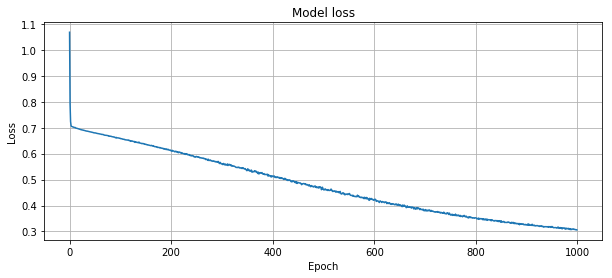

In [40]:
fig = plot_learning_curve(history,figsize=(10,4))